In [2]:
from rdkit.Chem import DataStructs
from tqdm import tqdm
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from matplotlib import pyplot as plt
import pandas as pd
from moses.metrics import weight, logP, SA, QED,mol_passes_filters
from moses.metrics.utils import get_mol, mapper

from rdkit import Chem
from rdkit.Chem import AllChem,Descriptors,Lipinski,DataStructs
from functools import partial
import numpy as np
from sklearn import manifold
import warnings
import random
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings('ignore')

/home/chensheng/anaconda3/envs/mtdd/lib/python3.8/site-packages/molsets-1.0-py3.8.egg/moses/metrics/utils.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  _mcf.append(_pains, sort=True)['smarts'].values]


In [3]:
def get_fps(path,sep=','):
    df=pd.read_csv(path,sep)
    mol_list=[]
    titles=[]
    for smiles,title in zip(df['SMILES'],df['Title']):
        mol=Chem.MolFromSmiles(smiles)
        if mol:
            mol_list.append(mol)
            titles.append(title)
    print(len(mol_list)/len(df))

    fps=[]
    for mol in mol_list:
        fps.append(GetMorganFingerprintAsBitVect(mol,2,1024))
    return fps,titles

In [4]:
from iter_gen import task
task_name='rorgt_dhodh'
target1,target2=task_name.split('_')
reinvent=(get_fps(f'data/compare/{task_name}/ReINVENT.csv'),'purple',10)
rationaleRL=(get_fps(f'data/compare/{task_name}/RationaleRL.csv'),'green',10)
mars=(get_fps(f'data/compare/{task_name}/MARS.csv'),'orange',10)
gen=(get_fps(f'data/compare/{task_name}/AIxFuse.csv'),'red',10)
rorgt=(get_fps(f'data/compare/{task_name}/{target1}.csv'),'black',10)
dhodh=(get_fps(f'data/compare/{task_name}/{target2}.csv'),'grey',10)
jmc=(get_fps(f'data/compare/{task_name}/JMC.csv'),'blue',100)

use GPU
0.9987
1.0
1.0
1.0
1.0
1.0
1.0


In [31]:

df_mmbgsa=pd.read_csv('data/outputs/mmbgsa/mmgbsa_137.csv')
ind_list=[]
scores=[]
df_mmbgsa['total']=df_mmbgsa['mmgbsa_rorgt']+df_mmbgsa['mmgbsa_dhodh']
df_mmbgsa.sort_values('total',inplace=True)
mols=[]
mols1=[]
mols2=[]
r1s=[]
r2s=[]
for title,smiles,rationale1,rationale2,score1,score2,smiles1,smiles2 in zip(df_mmbgsa['Title'],df_mmbgsa['SMILES'],df_mmbgsa['Rationale1'],df_mmbgsa['Rationale2'],df_mmbgsa['mmgbsa_rorgt'],df_mmbgsa['mmgbsa_dhodh'],df_mmbgsa['sim3d_2d_rorgt_smiles'],df_mmbgsa['sim3d_2d_dhodh_smiles']):
    try:
        mol=Chem.MolFromSmiles(smiles)
        mols.append(mol)
        mols1.append(Chem.MolFromSmiles(smiles1))
        mols2.append(Chem.MolFromSmiles(smiles2))
        r1s.append(Chem.MolFromSmiles(rationale1))
        r2s.append(Chem.MolFromSmiles(rationale2))
        ind=gen[0][1].index(title)
        # if score1 <-60 and score2 <-40:
        if True:
            ind_list.append(ind)
            scores.append(score1+score2)
    except:
        continue


138
[-146.85, -146.73, -142.73000000000002, -142.4, -140.99, -139.46, -138.51, -137.86, -137.51999999999998, -136.3, -135.47, -134.71, -132.95, -128.3, -126.42, -126.34, -125.85, -124.91999999999999, -123.37, -122.33, -121.63, -121.12, -120.25, -119.44999999999999, -119.43, -118.32, -118.3, -117.9, -117.13, -116.94, -116.74000000000001, -116.36, -115.64999999999999, -115.44, -115.09, -115.03, -114.86, -114.57, -114.31, -114.30000000000001, -114.30000000000001, -113.6, -113.58, -113.39, -112.6, -112.37, -110.86, -110.79, -110.71000000000001, -110.66999999999999, -110.09, -109.97, -109.57, -109.53, -109.41, -109.36, -108.97, -108.58, -108.46000000000001, -108.22999999999999, -108.08, -108.00999999999999, -107.83, -107.66, -107.65, -107.6, -107.41999999999999, -107.36, -106.95, -106.86, -106.84, -106.23, -106.07, -105.93, -105.5, -105.49000000000001, -105.44999999999999, -105.11, -104.85, -104.66, -104.66, -104.64, -104.41999999999999, -104.4, -104.08, -103.27, -103.27, -102.94, -102.36, 

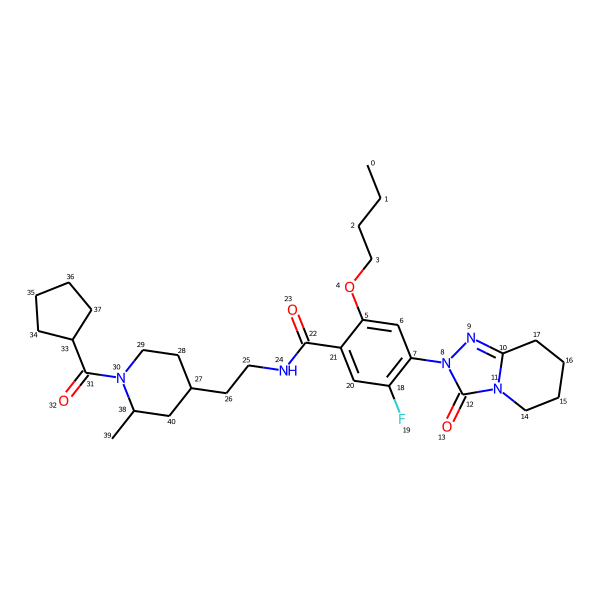

In [69]:
from copy import copy 
mol=copy(mols[16])
for atom in mol.GetAtoms():
    atom.SetProp('atomNote',str(atom.GetIdx()))
Chem.Draw.MolsToGridImage([mol],molsPerRow=1,subImgSize=(600,600),maxMols=300)

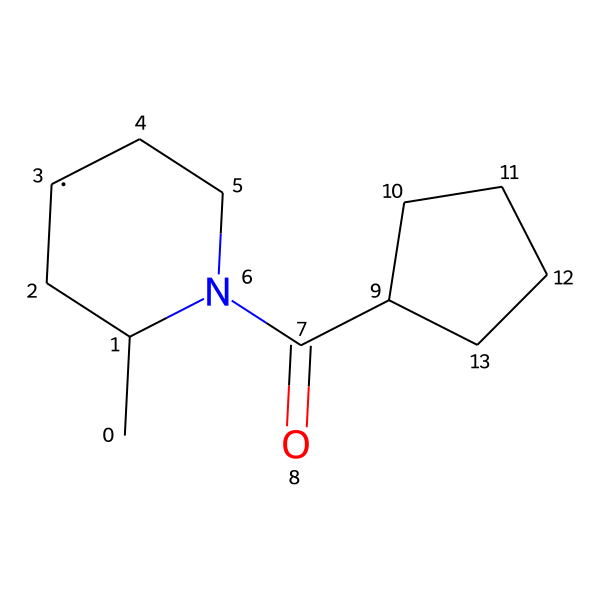

In [71]:
from copy import copy 
mol=copy(r1s[16])
for atom in mol.GetAtoms():
    atom.SetProp('atomNote',str(atom.GetIdx()))
Chem.Draw.MolsToGridImage([mol],molsPerRow=1,subImgSize=(600,600),maxMols=300)

In [79]:
print(len(ind_list))
print(scores)
from rdkit.Chem import Draw
for i in [0,2,4,6,16,26,73,124]:
    hit_atom1=mols[i].GetSubstructMatch(r1s[i])
    if i==16:
        hit_atom1=(39,38,40,27,28,29,30,31,32,33,34,35,36,37)
    hit_bond1 = []
    for bond in r1s[i].GetBonds():
        begin = hit_atom1[bond.GetBeginAtomIdx()]
        end = hit_atom1[bond.GetEndAtomIdx()]
        hit_bond1.append(mols[i].GetBondBetweenAtoms(begin, end).GetIdx())
    hit_atom2=mols[i].GetSubstructMatch(r2s[i])
    hit_bond2 = []
    for bond in r2s[i].GetBonds():
        begin = hit_atom2[bond.GetBeginAtomIdx()]
        end = hit_atom2[bond.GetEndAtomIdx()]
        hit_bond2.append(mols[i].GetBondBetweenAtoms(begin, end).GetIdx())
    atom_cols={}
    for atom in hit_atom1:
        atom_cols[atom]=(1,0.75,0.75)
    for atom in hit_atom2:
        atom_cols[atom]=(0.75,0.75,1)
    bond_cols={}
    for bond in hit_bond1:
        bond_cols[bond]=(1,0.75,0.75)
    for bond in hit_bond2:
        bond_cols[bond]=(0.75,0.75,1)
    print(atom_cols)
    d = Draw.rdMolDraw2D.MolDraw2DCairo(1500, 1500)
    print(len(mols[i].GetAtoms()),hit_atom1+hit_atom2)
    Draw.rdMolDraw2D.PrepareAndDrawMolecule(d, mols[i], highlightAtoms=hit_atom1+hit_atom2,
                                        highlightAtomColors=atom_cols,
                                        highlightBonds=hit_bond1+hit_bond2,
                                        highlightBondColors=bond_cols)
    with open(f'data/outputs/draw/t_sne/{i}.png', 'wb') as f:
        f.write(d.GetDrawingText())

138
[-146.85, -146.73, -142.73000000000002, -142.4, -140.99, -139.46, -138.51, -137.86, -137.51999999999998, -136.3, -135.47, -134.71, -132.95, -128.3, -126.42, -126.34, -125.85, -124.91999999999999, -123.37, -122.33, -121.63, -121.12, -120.25, -119.44999999999999, -119.43, -118.32, -118.3, -117.9, -117.13, -116.94, -116.74000000000001, -116.36, -115.64999999999999, -115.44, -115.09, -115.03, -114.86, -114.57, -114.31, -114.30000000000001, -114.30000000000001, -113.6, -113.58, -113.39, -112.6, -112.37, -110.86, -110.79, -110.71000000000001, -110.66999999999999, -110.09, -109.97, -109.57, -109.53, -109.41, -109.36, -108.97, -108.58, -108.46000000000001, -108.22999999999999, -108.08, -108.00999999999999, -107.83, -107.66, -107.65, -107.6, -107.41999999999999, -107.36, -106.95, -106.86, -106.84, -106.23, -106.07, -105.93, -105.5, -105.49000000000001, -105.44999999999999, -105.11, -104.85, -104.66, -104.66, -104.64, -104.41999999999999, -104.4, -104.08, -103.27, -103.27, -102.94, -102.36, 

In [9]:
Chem.Draw.MolsToGridImage(mols[:75*3],molsPerRow=6,subImgSize=(600,600),maxMols=300)

In [11]:
data=[]
color=[]
size=[]
for method in [reinvent,rationaleRL,mars,gen,rorgt,dhodh,jmc]:
# for method in [reinvent,rationaleRL,mars,gen,rorgt,dhodh]:
    data+=method[0][0]
    color+=[method[1]]*len(method[0][0])
    size+=[method[2]]*len(method[0][0])



In [12]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
X_fit = tsne.fit_transform(data)
x_min, x_max = X_fit.min(0), X_fit.max(0)
X_norm2 = (X_fit - x_min) / (x_max - x_min)  # 归一化

<Figure size 640x480 with 0 Axes>

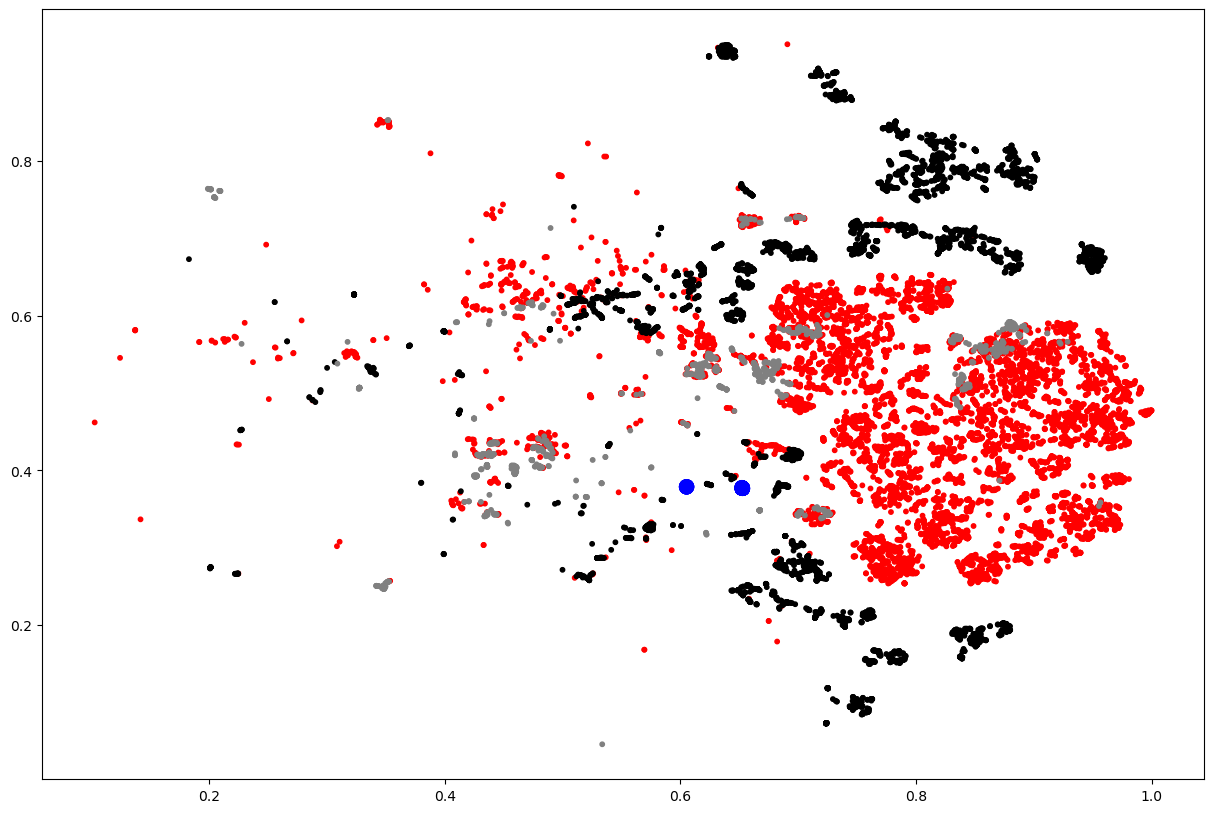

In [30]:
plt.clf()
# plt.rcParams['savefig.dpi'] = 600 #图片像素
# plt.rcParams['figure.dpi'] = 600 #分辨率
fig=plt.figure(figsize=(15,10))
# plt.xlabel('Project onto PC1',fontdict={'family' : 'Times New Roman', 'size'   : 20})
# plt.ylabel('Project onto PC2',fontdict={'family' : 'Times New Roman', 'size'   : 20})
# plt.xticks(fontproperties = 'Times New Roman', size = 16)
# plt.yticks(fontproperties = 'Times New Roman', size = 16)
# plt.grid(True,color="gray",linewidth="0.5",axis="both",zorder=0)
# prefix=0
prefix=len(reinvent[0][0])+len(rationaleRL[0][0])+len(mars[0][0])
plt.scatter(X_norm2[prefix:, 0], X_norm2[prefix:, 1], c=color[prefix:],s=size[prefix:],zorder=100)
# for i,ind in enumerate(ind_list):
#     # plt.scatter(X_norm2[prefix+ind, 0], X_norm2[prefix+ind, 1], c='#87CEEB',s=100 ,zorder=100)
#     if i in [0,2,4,6,16,26,73,124]:
#     # if i <30:
#         plt.text(X_norm2[prefix+ind, 0], X_norm2[prefix+ind, 1], f'{i}',zorder=101)
# index=2
# sim1_title=df_mmbgsa.iloc[index]['best_3d_2d_match_rorgt']
# sim1_ind=rorgt[0][1].index(str(sim1_title))
# print(sim1_title)
# sim1=prefix+len(gen[0][0])+sim1_ind
# sim2_title=df_mmbgsa.iloc[index]['best_3d_2d_match_dhodh']
# sim2_ind=dhodh[0][1].index(str(sim2_title))
# print(sim2_title)
# sim2=prefix+len(gen[0][0])+len(rorgt[0][0])+sim2_ind
# plt.scatter(X_norm2[sim1, 0], X_norm2[sim1, 1], c='yellow',s=100 ,zorder=102)
# plt.scatter(X_norm2[sim2, 0], X_norm2[sim2, 1], c='green',s=100 ,zorder=102)

plt.savefig(f'data/outputs/draw/t_sne/tsne_{task_name}.png')


In [ ]:
df1 =pd.read_csv('300.csv')
df2  =pd.read_csv('data/act_ligs/rorgt/rorgt.csv')
df3 =pd.read_csv('data/act_ligs/dhodh/dhodh.csv')
df4 =pd.read_csv('data/docking/results/JMC_design_dual_XP_prop.csv')
plt.clf()
rorgt_fps=[]
for smiles in df2['SMILES']:
    rorgt_fps.append(GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles),2,1024))
dhodh_fps=[]
for smiles in df3['SMILES']:
    dhodh_fps.append(GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles),2,1024))
gen_sim_dhodh=[]
gen_sim_rorgt=[]
for  smiles in tqdm(df1['SMILES']):
    fp=GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles),2,1024)
    gen_sim_rorgt.append(max(DataStructs.BulkTanimotoSimilarity(fp,rorgt_fps)))
    gen_sim_dhodh.append(max(DataStructs.BulkTanimotoSimilarity(fp,dhodh_fps)))
    if gen_sim_rorgt[-1] > 0.45 and gen_sim_dhodh[-1] > 0.45:
        print(gen_sim_rorgt[-1],gen_sim_dhodh[-1],smiles,df3['SMILES'][np.argmax(DataStructs.BulkTanimotoSimilarity(fp,dhodh_fps))],df2['SMILES'][np.argmax(DataStructs.BulkTanimotoSimilarity(fp,rorgt_fps))])
    if gen_sim_rorgt[-1] < 0.3 and gen_sim_dhodh[-1] < 0.3:
        print(gen_sim_rorgt[-1],gen_sim_dhodh[-1],smiles,df3['SMILES'][np.argmax(DataStructs.BulkTanimotoSimilarity(fp,dhodh_fps))],df2['SMILES'][np.argmax(DataStructs.BulkTanimotoSimilarity(fp,rorgt_fps))])
    if gen_sim_rorgt[-1] > 0.73:
        print(gen_sim_rorgt[-1],gen_sim_dhodh[-1],smiles,df3['SMILES'][np.argmax(DataStructs.BulkTanimotoSimilarity(fp,dhodh_fps))],df2['SMILES'][np.argmax(DataStructs.BulkTanimotoSimilarity(fp,rorgt_fps))])
    if gen_sim_dhodh[-1] > 0.86:
        print(gen_sim_rorgt[-1],gen_sim_dhodh[-1],smiles,df3['SMILES'][np.argmax(DataStructs.BulkTanimotoSimilarity(fp,dhodh_fps))],df2['SMILES'][np.argmax(DataStructs.BulkTanimotoSimilarity(fp,rorgt_fps))])

ref_sim_dhodh=[]
ref_sim_rorgt=[]
for  smiles in df4['SMILES']:
    fp=GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles),2,1024)
    ref_sim_rorgt.append(max(DataStructs.BulkTanimotoSimilarity(fp,rorgt_fps)))
    ref_sim_dhodh.append(max(DataStructs.BulkTanimotoSimilarity(fp,dhodh_fps)))
plt.xlabel('Max Similarity to RORgt Active Ligands.')
plt.ylabel('Max Similarity to DHODH Active Ligands.')
a=plt.scatter(gen_sim_rorgt, gen_sim_dhodh,s=20,color='orange',edgecolors='black')
b=plt.scatter(ref_sim_rorgt, ref_sim_dhodh,s=20,color='red',edgecolors='black')
# plt.legend((a,b),('AIxFuse','JMC'))
plt.savefig('similarity.png')


In [ ]:
import os
import glob
import moses
import pandas as pd
def eval_moses(task,compare_path):
    target1,target2=task.split('|')
    compare_dir=os.path.join(compare_path,f'{target1}_{target2}')
    target1_smiles=pd.read_csv(os.path.join(compare_dir,f'{target1}.csv'))['SMILES'].to_list()
    target2_smiles=pd.read_csv(os.path.join(compare_dir,f'{target2}.csv'))['SMILES'].to_list()
    statics_dict={'Method':[]}
    for csv in glob.glob(f'{compare_dir}/*'):
        df=pd.read_csv(csv)
        name=csv.split('/')[-1].split('.')[0]
        gen_smiles=df['SMILES'].to_list()
        print(csv,f'{name}_{target1}')
        statics_dict['Method'].append(f'{name}_{target1}')
        moses_result1=moses.get_all_metrics(gen=gen_smiles,test=target1_smiles,train=target1_smiles,n_jobs=64)
        for key in moses_result1:
            if key not in statics_dict:
                statics_dict[key]=[]
            statics_dict[key].append(moses_result1[key])
        print(csv,f'{name}_{target2}')
        statics_dict['Method'].append(f'{name}_{target2}')
        moses_result2=moses.get_all_metrics(gen=gen_smiles,test=target2_smiles,train=target2_smiles,n_jobs=64)
        for key in moses_result2:
            statics_dict[key].append(moses_result2[key])
    result_csv=os.path.join(compare_path,f'{target1}_{target2}.csv')
    statics_df=pd.DataFrame(statics_dict)
    statics_df.to_csv(result_csv,index=False)

In [ ]:
task='gsk3b|jnk3'
compare_path='/public/home/chensheng/project/aixfuse2/data/compare'
eval_moses(task,compare_path)